# Test Cases for Transient Analysis

In [1]:
from CircuitCalculator.Circuit.state_space_model import state_space_model
from CircuitCalculator.Circuit.circuit import Circuit
from CircuitCalculator.Circuit import components as cmp
from CircuitCalculator.Network import elements as elm
from CircuitCalculator.Network.network import Network, Branch
# from CircuitCalculator.Network.NodalAnalysis.state_space_model import NodalStateSpaceModel, BranchValues
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Test Case 1 - Single Capacitor

In [2]:
G1, G2, G3 = 10, 20, 30
R1, R2, R3 = 1/G1, 1/G2, 1/G3
R1, R2, R3 = 10, 20, 30
G1, G2, G3 = 1/R1, 1/R2, 1/R3
RC = 40e6
C = 1e-3
V0 = 5
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.resistor(id='R2', R=R2, nodes=('2', '0')),
    cmp.resistor(id='R3', R=R3, nodes=('2', '3')),
    cmp.capacitor(id='C', C=C, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])

### Setup Solution

In [3]:
def step(t: np.ndarray) -> np.ndarray:
    return np.heaviside(t, 1)

In [4]:
t_max = 0.3
t0 = 0.1
Ts = 0.0003
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)

### Calculate Solution

In [5]:
ss = state_space_model(circuit=circuit, potential_nodes=['1', '2', '3'], voltage_ids=['Uq', 'R1', 'R2', 'R3', 'C'], current_ids=['R1', 'R2', 'R3', 'C'])
sys = signal.StateSpace(ss.A, ss.B, ss.C, ss.D)
tout, yout, out = signal.lsim(sys, V, t)
print(ss.C)
print(ss.D)

[[ 0.        ]
 [ 0.18181818]
 [ 1.        ]
 [ 0.        ]
 [-0.18181818]
 [ 0.18181818]
 [-0.81818182]
 [ 1.        ]
 [-0.01818182]
 [ 0.00909091]
 [-0.02727273]
 [-0.02727273]]
[[1.00000000e+00]
 [5.45454545e-01]
 [2.02699810e-17]
 [1.00000000e+00]
 [4.54545455e-01]
 [5.45454545e-01]
 [5.45454545e-01]
 [2.02699810e-17]
 [4.54545455e-02]
 [2.72727273e-02]
 [1.81818182e-02]
 [1.81818182e-02]]


### Calculate Reference Solution

In [6]:
def pll(R1, R2):
    return R1*R2/(R1+R2)

Ri = pll(pll(R1, R2)+R3, RC)
tau = Ri*C
u2_ref = V*R2/(R1+R2)*(1+(R3*C/tau-1)*(np.exp(-(tout-t0)/tau)))
uc_ref = V*R2/(R1+R2)*(1-np.exp(-(tout-t0)/tau))
u3_ref = u2_ref - uc_ref
u1_ref = V - u2_ref

i1_ref = u1_ref/R1
i2_ref = u2_ref/R2
i3_ref = u3_ref/R3
ic_ref = C*V*R2/(R1+R2)/tau*np.exp(-(tout-t0)/tau)

### Plot Solution

(0.0, 0.3)

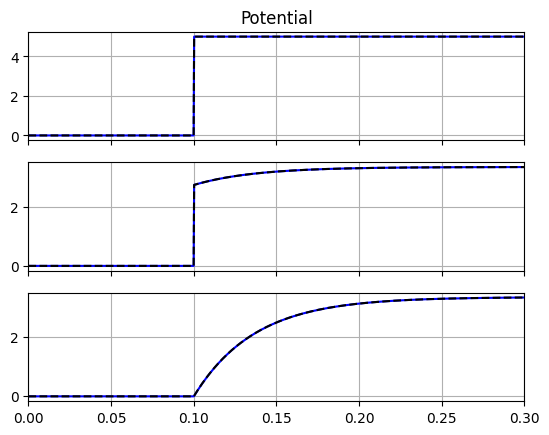

In [7]:
_, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(tout, yout[:,0], 'b-')
ax[0].plot(t, V, 'k--')
ax[0].grid(True)
ax[0].set_title('Potential')

ax[1].plot(tout, yout[:,1], 'b-')
ax[1].plot(tout, u2_ref, 'k--')
ax[1].grid(True)

ax[2].plot(tout, yout[:,2], 'b-')
ax[2].plot(tout, uc_ref, 'k--')
ax[2].grid(True)
ax[2].set_xlim((0, t_max))

(0.0, 0.3)

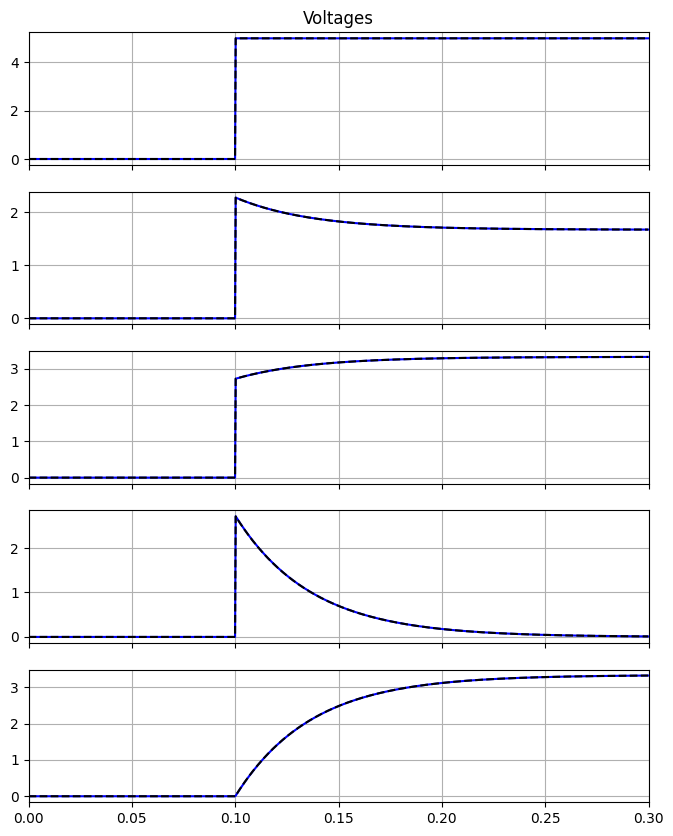

In [8]:
_, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 10))
ax[0].plot(tout, yout[:,3], 'b-')
ax[0].plot(t, V, 'k--')
ax[0].grid(True)
ax[0].set_title('Voltages')

ax[1].plot(tout, yout[:,4], 'b-')
ax[1].plot(tout, u1_ref, 'k--')
ax[1].grid(True)

ax[2].plot(tout, yout[:,5], 'b-')
ax[2].plot(tout, u2_ref, 'k--')
ax[2].grid(True)

ax[3].plot(tout, yout[:,6], 'b-')
ax[3].plot(tout, u3_ref, 'k--')
ax[3].grid(True)

ax[4].plot(tout, yout[:,7], 'b-')
ax[4].plot(tout, uc_ref, 'k--')
ax[4].grid(True)
ax[4].set_xlim((0, t_max))

(0.0, 0.3)

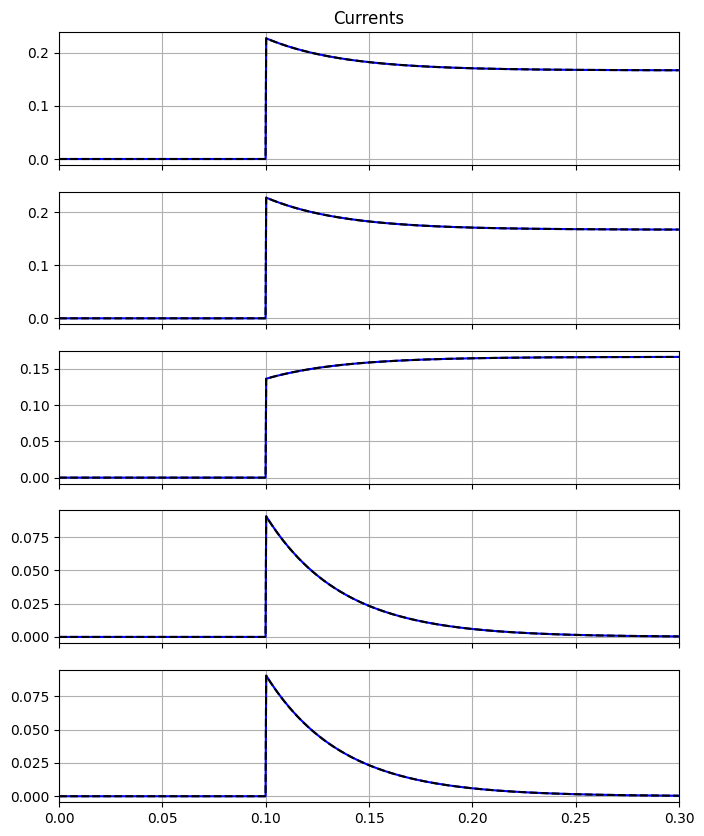

In [9]:
_, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 10))
ax[0].plot(tout, yout[:,8], 'b-')
ax[0].plot(t, i1_ref, 'k--')
ax[0].grid(True)
ax[0].set_title('Currents')

ax[1].plot(tout, yout[:,8], 'b-')
ax[1].plot(tout, i1_ref, 'k--')
ax[1].grid(True)

ax[2].plot(tout, yout[:,9], 'b-')
ax[2].plot(tout, i2_ref, 'k--')
ax[2].grid(True)

ax[3].plot(tout, yout[:,10], 'b-')
ax[3].plot(tout, i3_ref, 'k--')
ax[3].grid(True)

ax[4].plot(tout, yout[:,11], 'b-')
ax[4].plot(tout, ic_ref, 'k--')
ax[4].grid(True)
ax[4].set_xlim((0, t_max))

## Test Case 2 - Voltage and Current Source

In [10]:
R1, R2 = 10, 20
G1, G2 = 1/R1, 1/R2
RC = 40e6
C = 1e-3
V0 = 5
I0 = -0.1
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.capacitor(id='C', C=C, nodes=('2', '3')),
    cmp.resistor(id='R2', R=R2, nodes=('3', '0')),
    cmp.dc_current_source(id='Iq', I=I0, nodes=('0', '3')),
    cmp.ground(nodes=('0',))
])

In [11]:
network = Network([
    Branch(node1='1', node2='0', element=elm.NortenElement(name='Uq', type='voltage_source', Z=0, V=V0)),
    Branch(node1='1', node2='2', element=elm.NortenElement(name='R1', type='resistor', Z=R1, V=0)),
    Branch(node1='2', node2='3', element=elm.TheveninElement(name='C', type='capacitor', Y=1/RC, I=0)),
    Branch(node1='3', node2='0', element=elm.NortenElement(name='R2', type='resistor', Z=R2, V=0)),
    Branch(node1='0', node2='3', element=elm.TheveninElement(name='Iq', type='current_source', Y=0, I=I0))
])

### Setup Solution

In [12]:
t_max = 0.5
t0 = 0.1
t1 = 0.2
Ts = 0.0003
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)
I = I0*step(t-t1)

### Calculate Solution

In [13]:
ss = NodalStateSpaceModel(network=network, c_values=[BranchValues(value=C, id='C', node1='2', node2='3')])
sys = signal.StateSpace(ss.A, ss.B, ss.C, ss.D)
tout, yout, xout = signal.lsim(sys, np.column_stack([I, V]), t)

NameError: name 'NodalStateSpaceModel' is not defined

### Calculate Reference

In [ ]:
Ri = R1+R2
tau = Ri*C

uc_ref = np.zeros(t.size)
uc_ref[t>t0] = V0*(1-np.exp(-(tout[t>t0]-t0)/tau))
uc_ref[t>t1] = uc_ref[t>t1] - I0*R2*(1-np.exp(-(tout[t>t1]-t1)/tau))

ic_ref = np.zeros(t.size)
ic_ref[t>t0] = C*V0*(-np.exp(-(tout[t>0.1]-0.1)/tau))*(-1/tau)
ic_ref[t>t1] = ic_ref[t>t1] - C*I0*R2*(-np.exp(-(tout[t>t1]-t1)/tau))*(-1/tau)

phi1_ref = -ic_ref*R1 + V
phi2_ref = (ic_ref + I)*R2

### Plot Solution

In [ ]:
_, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 8))
ax[0].plot(tout, yout[:,0]-yout[:,1], 'b-')
ax[0].plot(tout, uc_ref, 'k--')
ax[0].grid(True)

ax[1].plot(tout, yout[:,0], 'b-')
ax[1].plot(tout, phi1_ref, 'k--')
ax[1].grid(True)

ax[2].plot(tout, yout[:,1], 'b-')
ax[2].plot(tout, phi2_ref, 'g--')
ax[2].grid(True)
ax[2].set_xlim((0, t_max))

## Test Case 3 - Two Capacitors

In [ ]:
V0 = 1
R1, R2 = 10, 20
RC = 40e6
C1 = 5e-3
C2 = 1e-3
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.capacitor(id='C1', C=C1, nodes=('2', '3')),
    cmp.resistor(id='R2', R=R2, nodes=('3', '0')),
    cmp.capacitor(id='C2', C=C2, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])

In [ ]:
network = Network([
    Branch(node1='1', node2='0', element=elm.NortenElement(name='Uq', type='voltage_source', Z=0, V=1)),
    Branch(node1='1', node2='2', element=elm.NortenElement(name='R1', type='resistor', Z=R1, V=0)),
    Branch(node1='2', node2='3', element=elm.TheveninElement(name='C1', type='capacitor', Y=1/RC, I=0)),
    Branch(node1='3', node2='0', element=elm.NortenElement(name='R2', type='resistor', Z=R2, V=0)),
    Branch(node1='3', node2='0', element=elm.TheveninElement(name='C2', type='capacitor', Y=1/RC, I=0))
])

### Setup Solution

In [ ]:
t_max = 0.5
t0 = 0.1
Ts = 0.0003
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)

### Calculate Solution

In [ ]:
ss = NodalStateSpaceModel(network=network, c_values=[BranchValues(value=C1, id='C1', node1='2', node2='3'), BranchValues(value=C2, id='C2', node1='3', node2='0')])
sys = signal.StateSpace(ss.A, ss.B, ss.C, ss.D)
tout, yout, xout = signal.lsim(sys, V, t)

### Calculate Reference

In [ ]:
def quad_equation(a, b, c):
    D = np.sqrt(b**2-4*a*c)
    return ((-b+D)/2/a, (-b-D)/2/a)

a = C2*R2
b = C1*R1
c = C1*R2
s1, s2 = quad_equation(1, (a+b+c)/a/b, 1/a/b)
s3, s4 = quad_equation(1, (a+b+c)/a/b, 1/a/b)

t_ref = tout[t>t0]-t0

uc1_ref = np.zeros(t.size)
uc1_ref[t>t0] = V0/a/b * (1/s1/s2 + 1/(s2-s1)*(-1/s1*np.exp(s1*t_ref)+1/s2*np.exp(s2*t_ref))) + V0/b * 1/(s1-s2) * (np.exp(s1*t_ref)-np.exp(s2*t_ref))

uc2_ref = np.zeros(t.size)
uc2_ref[t>t0] = V0*c/a/b * (np.exp(s3*t_ref)-np.exp(s4*t_ref))/(s3-s4)

phi1_ref = uc1_ref + uc2_ref

### Plot Solution

In [ ]:
_, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 8))
ax[0].plot(tout, yout[:,0]-yout[:,1], 'b-')
ax[0].plot(tout, uc1_ref, 'k--')
ax[0].grid(True)

ax[1].plot(tout, yout[:,0], 'b-')
ax[1].plot(tout, phi1_ref, 'k--')
ax[1].grid(True)

ax[2].plot(tout, yout[:,1], 'b-')
ax[2].plot(tout, uc2_ref, 'g--')
ax[2].grid(True)
ax[2].set_xlim((0, t_max))